In [1]:
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from qiskit import  Aer
simulator=Aer.get_backend('qasm_simulator')
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover
import numpy as np

C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\2301315631.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import AmplificationProblem


## Graph coloring problemm using Grover's  algorithm
There is an interesting way of solving the graph coloring problem using Grover's algorith proposed here:(https://medium.com/@shoaib6174/how-to-solve-the-graph-coloring-problems-using-qiskits-grover-algorithm-e87eb52f203). The basic idea consists on being able to map everything into an amplitude amplification problem,  for which we'll need two things:

1. Map the nodes and their respective colors into bit-strings.
2. Create an oracle which, using the information of the edges, signs the configurations in which no adjacet nodes have the same color.

$\textit{The first part}$ is simple, since what can be done is the following: Suppose we have one node which can be painted with four different colors, this can be represented  as:

$$00\longrightarrow  \text{red node},$$
$$01\longrightarrow  \text{green node},$$
$$10\longrightarrow  \text{blue node},$$
$$11\longrightarrow  \text{black node},$$

i.e, for each node, two qubits will be used. In this way we'll have, for example, that the bit  string $110101$ is associated to  one black node  and two green nodes.

$\textit{The second part}$ is a bit more complicated. Let's start with  the simples case possible, that is, two nodes joined by one edge. The first node is codified on qbits $(q_0,q_1)$ and the second on qbits $(q2,q3)$. The nodes will have different colors if $q_0 \neq q_2$ or $q_1 \neq q_3$, which when put into a function it reads
$$f(q_0,q_1,q_2,q_3)=1,\quad if \quad (q_0 \neq q_2)\lor (q_1 \neq q_3)$$
$$\quad \quad \quad \quad \quad \quad \quad=1, \quad  if \quad \neg ((q_0 = q_2)\wedge (q_1 = q_3))$$

The previous step  was done since it's easy to check wheter two qubits are in the same state (given that  they  are in a state of the computational basis) and send this information to an auxiliary qubit. Naming the auxiliary qubit $\text{check}$, we try to build  the gate
$$U|q_0,q_1,q_2,q_3,check \rangle = |q_0,q_1,q_2,q_3,check \oplus f(q_0,q_1,q_2,q_3) \rangle $$

The previous is done since, noting $\vec{q}=(q_0,q_1,q_2,q_3)$, if the check qubit starts on $|-\rangle$, we see that
$$U|\vec{q},-\rangle= |\vec{q}\rangle\left( \frac{|0 \oplus f(\vec{q})\rangle - |1 \oplus f(\vec{q})\rangle}{\sqrt{2}}\right )=(-1)^{f(\vec{q})}|\vec{q}\rangle |-\rangle,$$
that is, $U$ signs $|\vec{q}\rangle$ if $\vec{q}$ is associated to a configuration in which adjacent nodes have different colors, so the solutions can be amplified using Grovers algorith!. 

This first oracle is constructed below.


In [2]:
def two_node_check(qc, qubits_a, qubits_b, check_qubit):

  # 1. Check if the qubits are in the 11 11 state.
  qc.mct(qubits_a + qubits_b, check_qubit)

  # 2. Check if the qubits are in the 10 10 state.
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])

  # 3. Check if the qubits are in the 01 01 state.
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
    
  # 4. Check if the qubits are in the 00 00 state.
  qc.x(qubits_a)
  qc.x(qubits_b)
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a)
  qc.x(qubits_b)

  # 5. Negation of the above result.
  qc.x(check_qubit)

Victory can't be declared  yet, since the previous was for a rather trivial case. Nevertheless it will be useful when moving to the general problem. To treat the situation with $n$ nodes and $m$ edges, we'll first represent this information with an array, that we will call $\textit{Edges}$. Edges will have m components, one per edge on the graph, and each component will have two elements(the linked nodes), which will in turn each have the information of the qubits to which each node is associated to.

To illustrate the previous, suppose we want to represent 3 nodes connected by 3 edges(the triangle topology). Associating node 1 to qubits $(q_0,q_1)$, node 2 to qubits  $(q_2,q_3)$ and node 3 to qubits $(q_4,q_5)$, the edges vector would be

In [3]:
variable_qubits = [0, 1, 2, 3, 4, 5] # 6 qbits to represent 6 nodes with  4 different color possibilities
Edges = [[[0, 1], [2, 3]],
        [[0, 1], [4, 5]],
        [[2,3], [4, 5]]
                ]

The first element says nodes 1 and 2 are connected, the second element that nodes 1 and 3 are connected and the  third element that  nodes 2 and 3 are connected.

Now that we have a way to abstract the graph into code, for a given coloring we should make an oracle that:

1. Goes through the Edges array and checks wheter each pair of joined nods have different colors.
2. If all checks are satisfied, flips the state of an auxiliary bit(so that the previously discussed trick with the $|-\rangle$ state can be used to sign a useful coloring).

The two previous requirements imply that, first, for every edge we must have a check qubit(since we need the information of all edges to see wether a coloring was succesful or not), and second, we need a final ancilla qubit to sign the state, which we will call $\textit{target}$.

With the already built 'two_node_check' function, the construction of the  general oracle seems straight forward, since we'd only need to go through all the edges with the function, build the gates associated to the comparisson of the two nodes, and end with a multi-controlled from the check qubits to the target qbit. $\textit{Nevertheless}$, there's a small subtlety and it's that now  the check qubits are ideally not going to be preset on $|-\rangle$ but on $|0\rangle$, so that their values can be properly flipped if the colors are different and then used for the multi-controlled not. The previous brings an issue, and it's that since we want to use the oracle many times we need a way to reste the check qubits, but it can be esaily solved by applying the inverse of the 'two_node_check' after the evaluation of wheter a given coloring was succesful or not.

Due to the previous, we  program the following function,

In [4]:
def reset_check(qc, qubits_a, qubits_b, check_qubit):
  
  # 5. Undo The negation.
  qc.x(check_qubit)
    
  # 4. Undo the Check if the qubits were in 00 00.
  qc.x(qubits_a)
  qc.x(qubits_b)
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a)
  qc.x(qubits_b)


  # 3. Undo the check if the qubits were in 01 01.
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])

  # 2. Undo the check if the qubits were in 10 10.
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])

  # 1. Undo the check if the qubits were in 11 11.
  qc.mct(qubits_a + qubits_b, check_qubit)

Now that everything is ready, we can finally loop over $\textit{Edges}$ and use 'two_node_check' to build the final oracle as follows,

In [5]:
def graph_color_oracle(Edges, variable_qubits, check_qubits, target_qubit):

  num_vars = len(variable_qubits)
  num_checks = len(check_qubits)

  # 1. Initializing a quantum circuit with the target qubit in the |−⟩ state.
  oracle = QuantumCircuit(num_vars + num_checks + 1)
  oracle.x(target_qubit)
  oracle.h(target_qubit)

  # 2. Checking wheter each pair of joined nodes has a different color.
  for edge in range(len(Edges)):
    two_node_check(oracle,Edges[edge][0],Edges[edge][1],check_qubits[edge])

  # 3. Flip the target if all adjacent nodes have different colors.
  oracle.mct(check_qubits, target_qubit)
  
  # 4. Resetting the checks  
  for edge in range(len(Edges)):
    reset_check(oracle,Edges[edge][0],Edges[edge][1],check_qubits[edge])

  return oracle

Now everything is ready to implement Grover's algorithm, we simply need toset all the variable qubits in an even superposition and set the number of times which the algorithm will be ran.

In [6]:
def graph_color_prep(variable_qubits):
  
  num_vars = len(variable_qubits)
  prep = QuantumCircuit(num_vars)
  # Set the variable qubits to |+>^n
  for i in range(num_vars):
    prep.h(i)

  return prep

Now, as a last remark, given a function with $M$ marked elements, ideally the loops over Grover's algorith should be
$$ loops= \frac{\pi}{4}\sqrt{\frac{2^{qubits}}{M}}.$$

Since for the first example we have a triangle topology, if there is at least one solution, there will be $3!$ solutions or more, since any permutation of colors over the nodes will also be a solution, so we'll(roughly) estimate $M=3!$.

In [7]:
# Check and target qubits
check_qubits = [6, 7, 8]
target_qubit = 9

# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(Edges, variable_qubits, check_qubits, target_qubit)


# DEFINE THE AmplificationProblem

problem = AmplificationProblem(oracle, state_preparation = prep, objective_qubits = variable_qubits)
loops=round(np.pi*np.sqrt(2**(6)/(3*2))/4) # Estimation of ideal number of loops
grover = Grover(iterations = loops, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(q

To test the results given by Grover's algorithm, a brute  force check will be performed over all possibilities, so that later on the histogram the bars associated to succesful possibilities will be painted orange and the rest will be paited blue.

In [8]:
def brute_force_check(state, Edges):
    
  for edge in range(len(Edges)):
    if (state[Edges[edge][0][0]] == state[Edges[edge][1][0]]
        and state[Edges[edge][0][1]] == state[Edges[edge][1][1]]):
        return False 

  return True

In [9]:
def plot_results(result, brute_force, Edges):

  # Plotting results
  counts = result.circuit_results[0]
  plot = plot_histogram(counts, figsize=(int(6*len(counts.keys())**(1/2)), 8), sort='value_desc')
  ax = plot.gca()
  ax.tick_params(axis='x', which='major', labelsize=30)
  ax.set_xlabel("State", fontsize = '60')
  ax.set_ylabel("Count", fontsize = '60')


  correct_count = 0
  states = ax.xaxis.get_ticklabels()
  for i in range(len(states)):
    if brute_force(states[i].get_text(),Edges):
      ax.containers[i][0].set(color = 'orange')
      correct_count += 1
    else:
      ax.containers[i][0].set(color = 'blue')

  leg = plot.legend(['Incorrect (' + str(len(states) - correct_count) + ' counted)',
                     'Correct (' + str(correct_count) + ' counted)'],
                    fontsize = '70',
                    loc = 'upper right')
  leg.legendHandles[0].set_color('blue')
  leg.legendHandles[1].set_color('orange')
  #ax.set_xlim(40,0)

  display(plot)

C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3238223214.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3238223214.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')


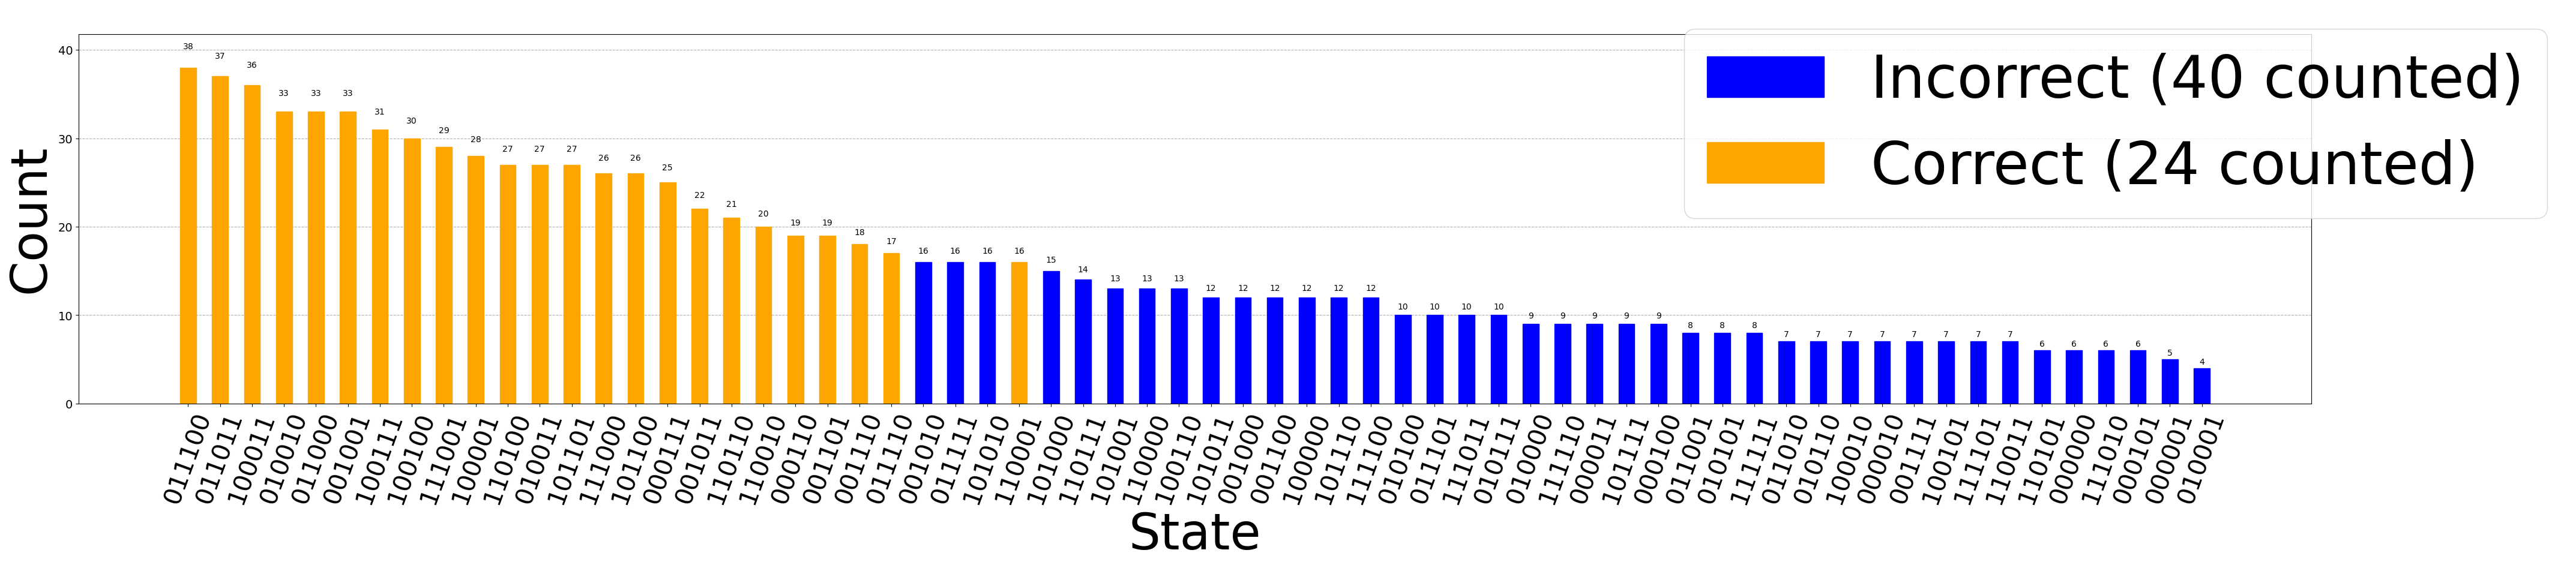

In [10]:
plot_results(results, brute_force_check, Edges)

As we can see, Grover's algorith  was able to accurately highlight the solutions for the triangle topology!. To put it more to the  test, we'll try it with 4  fully connected nodes and see the results.

C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(q

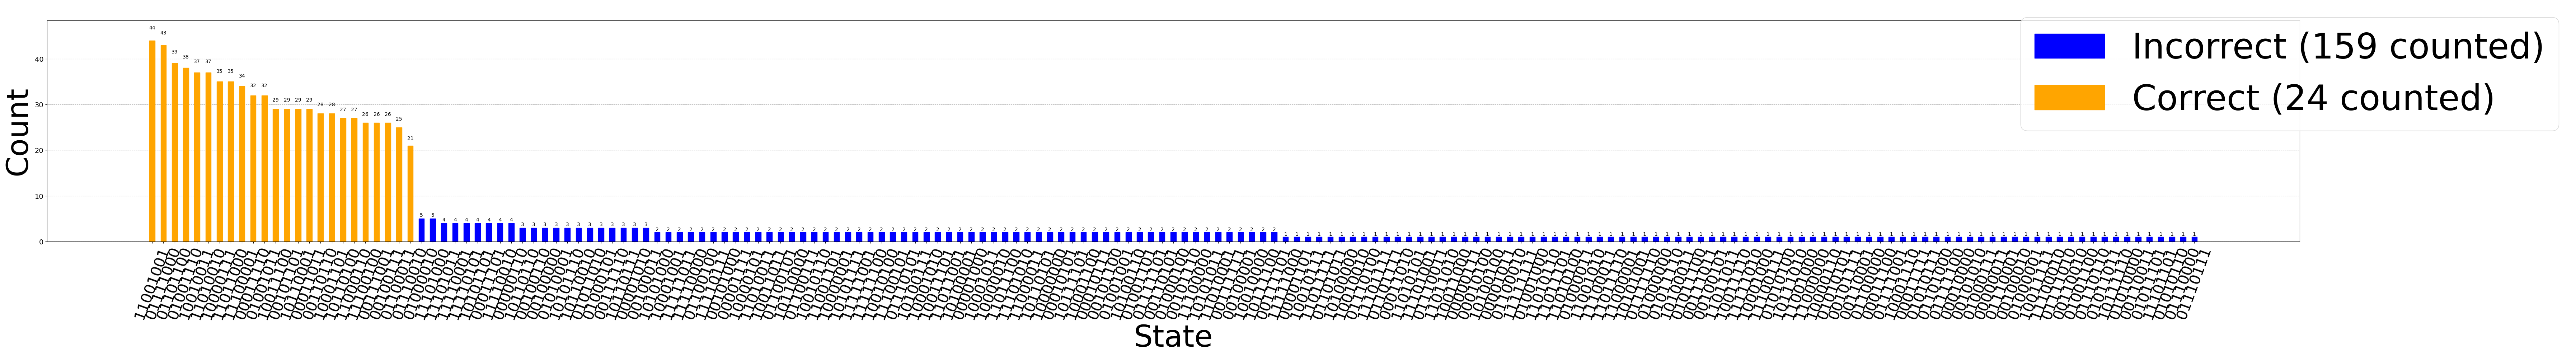

In [11]:
# 4 fully connected nodes

# Defining the qubits and edges

variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7] # 8 qbits to represent 4 nodes with  4 different color possibilities
Edges = [ [[0, 1], [2, 3]],
                  [[0, 1], [4, 5]],
                  [[0, 1], [6, 7]],
                  [[2,3], [4, 5]],
                  [[2, 3], [6, 7]],
                  [[4, 5], [6, 7]]
                 ]
check_qubits = [8, 9, 10, 11, 12, 13] # one check per edge
target_qubit = 14

# oracle
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(Edges, variable_qubits, check_qubits, target_qubit)

# AmplificationProblem
problem = AmplificationProblem(oracle, state_preparation = prep, objective_qubits = variable_qubits)
loops=round(np.pi*np.sqrt(2**(8)/(4*3*2))/4) # Estimation of ideal number of loops
grover = Grover(iterations = loops, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

#plotting

plot_results(results, brute_force_check, Edges)

So yet again the solutions where  amplified and even better than befor since the number of solutions actually is $M=4!$.

$\textbf{Nevertheless}$, although so far it seems like Grove's algorithm is a perfect tool for tackling the graph coloring problem, there's a HUGE issue which we haven't discussed enough, namely, the number of iterations on Grover's algorith. The ideal amount of times depends the number of marked elements $M$ as $\sqrt{2^{qubits}/M}$, but $\textit{in principle we don't know $M$}$, therefore we'd have to make a guess which will most likely be innacurate.

As an example, we try to solve for the square topology using the same number of iterations as for the fully connected topology, and see what happens.

C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\Jose\AppData\Local\Temp\ipykernel_18608\3430845180.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(q

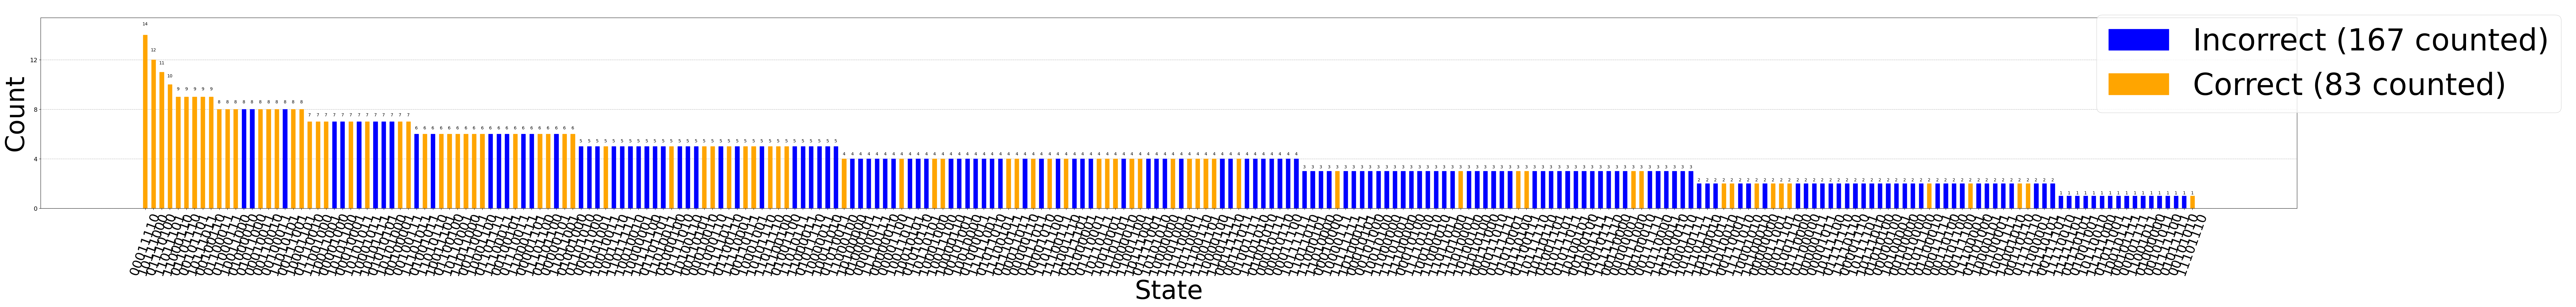

In [12]:
# Square topology

# Defining the qubits and edges

variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7] # 8 qbits to represent 4 nodes with  4 different color possibilities
Edges = [ [[0, 1], [2, 3]],
                  [[2, 3], [4, 5]],
                  [[4, 5], [6, 7]],
                  [[6,7], [0, 1]]
                 ]
check_qubits = [8, 9, 10, 11] # one check per edge
target_qubit = 12

# oracle
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(Edges, variable_qubits, check_qubits, target_qubit)

# AmplificationProblem
problem = AmplificationProblem(oracle, state_preparation = prep, objective_qubits = variable_qubits)
loops=round(np.pi*np.sqrt(2**(8)/(4*3*2))/4) # Estimation of ideal number of loops
grover = Grover(iterations = loops, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

#plotting
plot_results(results, brute_force_check, Edges)

In conclusion, although an oracle that signs the solutions to the map coloring problem for a given topologyh can be created, the lack of knowledge on the number of solutions(if there's any) greatly affects the effectiveness of the use of Grover's algorithm.